#  Predicción de Precios de Vivienda en Boston

En este notebook se construirá un modelo de regresión para predecir los precios de la vivienda en Boston. Particularmente se utilizará un modelo de red neuronal. 

El objetivo es hacer un modelo que permita predecir el valor promedio de un apartamento que pertenezca a esa ciudad. Para llevar esta tarea a cabo, se utilizarán datos los datos de una competencia de Kaggle link o directamente desde los Datasets de Sci-Kit Learn. Por cuestiones de replicación utilizaremos la segunda fuente.

Para ello se comienza con importar el módulo de datasets de la librería sci-kit learn.

In [13]:
from sklearn import datasets
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler


# 1. Carga de Información

In [2]:
precios_vivienda = datasets.load_boston()

In [3]:
print(precios_vivienda.keys())

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename'])


La celda anterior muestra que la variable precios_vivienda corresponde a un diccionario que contiene los datos explicativos en data y la variable objetivo en target. Adicionalmente, se puede observar que se tiene información de 13 características para 506 apartamentos de Boston.

In [4]:
N, k = precios_vivienda.data.shape
print(f'Cantidad de Apartamentos: {N}\nCantidad de Características: {k}')

Cantidad de Apartamentos: 506
Cantidad de Características: 13


Las variables que contiene este dataset son, en orden:

- **CRIM:**     Tasa de criminalidad per-cátida
- **ZN:**       Proporción de predios que superan los 25,000 sq.ft.
- **INDUS:**    Proporción de negocios que no son de retail
- **CHAS:**     Variable Dummy del Río Charles
- **NOX:**      Concentración de Óxio de Nitrógino (partes por 10 millones)
- **RM:**       Número promedio de habitaciones
- **AGE:**      Proporción de viviendas construídas antes de 1940
- **DIS:**      Distancia ponderada a principales centros de trabajo
- **RAD:**      Índice de Accesibilidad a autopistas radiales
- **TAX:**      Razón de Impuesto por cada 10.000
- **PTRATIO:**  Cantidad de estudiantes por profesor en la ciudad
- **B:**        $1000(Bk - 0.63)^2$ donde Bk es la proporción de personas de color en el pueblo
- **LSTAT:**    % de Población de Estratos Bajos
- **MEDV:**     Median value of owner-occupied homes in $1000's


Se puede apreciar quque las variables se encuentran en rangos similares, siendo la PTRATIO la que tiene la escala más disímil. 

In [6]:
pd.DataFrame(precios_vivienda.data).describe().transpose()

,count,mean,std,min,25%,50%,75%,max
0,506.0,3.613524,8.601545,0.00632,0.082045,0.25651,3.677083,88.9762
1,506.0,11.363636,23.322453,0.00000,0.000000,0.00000,12.500000,100.0000
2,506.0,11.136779,6.860353,0.46000,5.190000,9.69000,18.100000,27.7400
3,506.0,0.069170,0.253994,0.00000,0.000000,0.00000,0.000000,1.0000
4,506.0,0.554695,0.115878,0.38500,0.449000,0.53800,0.624000,0.8710
5,506.0,6.284634,0.702617,3.56100,5.885500,6.20850,6.623500,8.7800
6,506.0,68.574901,28.148861,2.90000,45.025000,77.50000,94.075000,100.0000
7,506.0,3.795043,2.105710,1.12960,2.100175,3.20745,5.188425,12.1265
8,506.0,9.549407,8.707259,1.00000,4.000000,5.00000,24.000000,24.0000
9,506.0,408.237154,168.537116,187.00000,279.000000,330.00000,666.000000,711.0000


# 2. Train-Test Split

En esta sección se realiza la partición entre entrenamiento, validación y prueba. Se realizará una partición inicial del dataset en 80-20%. De forma que se utilizará el 80% de la información para entrenar y validar el modelo, y el 20% restante se utilizará para conocer el desempeño del modelo a la hora de predecir los precios de vivienda en datos nuevos. 

In [8]:
X = precios_vivienda.data
y = precios_vivienda.target

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

In [38]:
print(f'Tamaño de Información:\nEntrenamiento: {round(len(X_train)/len(X)*100, 1)}%.\n   Validación: {round(len(X_val)/len(X)*100, 1)}%. \n       Prueba: {round(len(X_test)/len(X)*100, 1)}%.')

Tamaño de Información:
Entrenamiento: 63.8%.
   Validación: 16.0%. 
       Prueba: 20.2%.


# 3. Reescalado de Información

Anteriormente se vio que alguans de las variables de vivienda tenían escalas muy diferentes. Por esta razón, se decide hacer un Min-Max Scaler, haciendo que las variables se encuentren en el intervalo [0, 1], facilitando a la velocidad de convergencia del modelo de red neuronal.

Este Min-Max scaler será construído tomando los valores máximos y mínimos de cada variable del *conjunto de entrenamiento*, y utilizando estas se transformarán las variables de entrenamiento, validación y prueba.

In [39]:
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# 4. Modelo de Red Neuronal para Clasificación Binaria

En este apartado se realizará la construcción y estimación de red neuronal. Este modelo tendrá como entrada 12 variables (cada una de las mediciones obtenidas de las imágenes), pasarán por una capa oculta compuesta por 4 neuronas para reducir su dimensón y posteriormente pasarán a la capa de salida que consta de una neurona con activación lineal. 

Esta red neuronal buscará optimizar la función de pérdida "Mean Squared Error", dada por, 

$$MSE = \frac{1}{N} \sum_{i = 1}^N (y_i - \hat{y}_i)^2$$

donde $y_i$ es el precio de la $i$-ésima vivienda y  \hat{y}_i corresponde al precio estimado de esa vivienda según el modelo. 

In [40]:
model = tf.keras.models.Sequential([
            tf.keras.layers.Dense(4, activation='relu'),
            tf.keras.layers.Dense(1)
])

In [41]:
earlystopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)


model.compile(optimizer='adam',
              loss='mse',
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

Adicionalmente, este modelo será entrenado con una regla de EarlyStopping. De esta forma, el entrenamiento es detenido después de 3 epochs en que la pérdida en el conjunto de validación  no disminuya, previniendo un posible sobreajuste del modelo a los datos de entrenamiento. 

In [42]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=1000, callbacks = [earlystopping_callback], verbose = 1)

p - loss: 29.6045 - root_mean_squared_error: 5.4366 - val_loss: 24.2856 - val_root_mean_squared_error: 4.9280
Epoch 493/1000
11/11 [==============================] - 0s 5ms/step - loss: 32.4370 - root_mean_squared_error: 5.6745 - val_loss: 24.2439 - val_root_mean_squared_error: 4.9238
Epoch 494/1000
11/11 [==============================] - 0s 5ms/step - loss: 28.6252 - root_mean_squared_error: 5.3437 - val_loss: 24.1923 - val_root_mean_squared_error: 4.9186
Epoch 495/1000
11/11 [==============================] - 0s 4ms/step - loss: 32.6989 - root_mean_squared_error: 5.7139 - val_loss: 24.1662 - val_root_mean_squared_error: 4.9159
Epoch 496/1000
11/11 [==============================] - 0s 5ms/step - loss: 29.6863 - root_mean_squared_error: 5.4423 - val_loss: 24.1285 - val_root_mean_squared_error: 4.9121
Epoch 497/1000
11/11 [==============================] - 0s 4ms/step - loss: 28.0738 - root_mean_squared_error: 5.2808 - val_loss: 24.0992 - val_root_mean_squared_error: 4.9091
Epoch 498/

# 6. Evaluación del Modelo

En esta sección se realiza la evaluación del modelo anteriormente entrenado. Para esto se realizará un gráfico del entrenamiento de la red neuronal para asegurar que no hubo luagar al sobreajuste durante el entrenamiento. 

In [43]:
metrics = pd.DataFrame(model.history.history)

In [44]:
metrics.head()

,loss,root_mean_squared_error,val_loss,val_root_mean_squared_error
0,590.729919,24.304935,551.248291,23.478678
1,584.088318,24.167919,545.178223,23.349052
2,577.545349,24.032173,539.111511,23.218775
3,571.003113,23.895672,533.035278,23.087557
4,564.572998,23.760744,527.124390,22.959190


<AxesSubplot:>

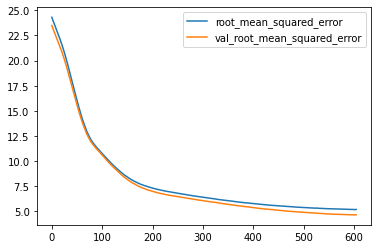

In [45]:
metrics[['root_mean_squared_error', 'val_root_mean_squared_error']].plot()

# 7. Desempeño en Test
En esta sección se analizará el desempeño del modelo en la base de test que se dejó por fuera para analizar cómo se compartará el modelo en datos nunca antes vistos. 

A continuación se generan las predicciones de los individuos en X_test. Se presentará el RMSE en este conjunto de información, al igual que un diagrama de dispersión entre precios predichos y precios reales.

## 7.1 Gráfico de Dispersión

En el siguiente gráfico se presenta la dispersión entre las predicciones y los valores reales de precios de vivienda en Boston. Se puede observar cómo 

In [47]:
y_pred = model.predict(X_test)
y_true = y_test

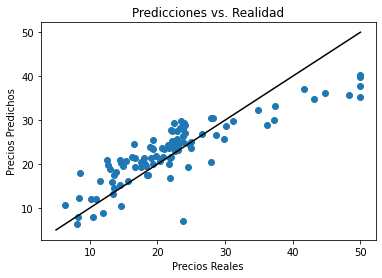

In [56]:
plt.scatter(y_true, y_pred)
plt.plot([5, 50], [5, 50], color = 'black')
plt.xlabel('Precios Reales')
plt.ylabel('Precios Predichos')
plt.title('Predicciones vs. Realidad')
plt.show()

In [52]:
mean_squared_error(y_true, y_pred)**0.5

5.126992301896575